In [1]:
import numpy as np
from tqdm.notebook import tqdm

from neurodsp.sim import sim_oscillation, sim_powerlaw
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF
from bycycle import Bycycle

from ndspflow.core.workflow import WorkFlow

# WorkFlow Class

`WorkFlow` objects wrap analyses that are typically functionally oriented into a unified object. This allows for reproducible analyses and a clear order of operations, from raw input array to the final output measure. This class consist of three types of nodes:

1. __Input__ : Defines the raw input numpy array, including simulations, reading BIDS structure, or custom classes or functions to read in raw binary data.
    
2. __Transformations__ : Defines the order of preprocessing operations used to manipulate the raw array input. Any function that accepts an y-array, and returns an y-array, with or without an x-array, are support. This allows interfacing of signal processing packages, such as `scipy`, `numpy`, `mne`, `neurodsp`, etc. Examples: filtering, re-referencing, ICA, frequency domain transformations, etc.

3. __Models__ : Defines the model class that is used to fit or extract values out of the transformed array. Models should be initialized and contain a `fit` method that accepts array definitions. Examples: `fooof`, `bycycle`.

4. __Forks__ : Forks refer to the splitting of the workflow into multiple streams. Forks may optionally have additional transform (e.g. one model may want power spectra, whereas another requires time series). A `fit` method call must follow after every fork.

## Overview

Below a workflow example is defined and executed. After, we break down each method call in greater detail. 

For now, the `.plot()` method of the `WorkFlow` class plots the graph of the workflow. The `.fork(index)` method is used to split the workflow into sub-flows. The first`.fork(0)` call with a unique index argument creates a save state at the point of the call. Subsequent `.fork(0)` calls restores that state at the time of the inital call before proceding. New `.fork(1)` calls create a new save state that can be later restored.

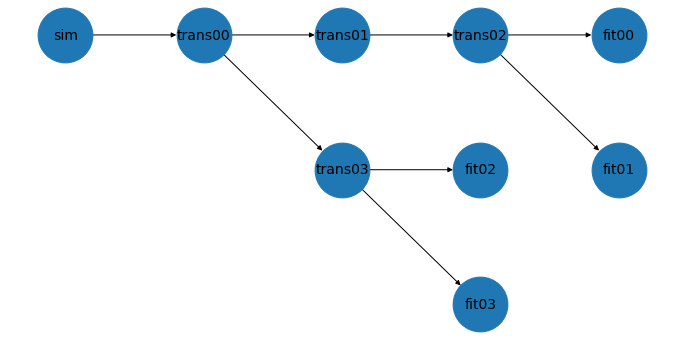

In [2]:
# Settings
n_seconds = 10
fs = 1000
seeds = list(range(4))
freq_range = (1, 100)

# Workflow
wf = WorkFlow(seeds=seeds)

# Simulate
wf.simulate(sim_powerlaw, n_seconds, fs, exponent=-2)
wf.simulate(sim_oscillation, n_seconds, fs, freq=10, operator='add')
wf.simulate(sim_oscillation, n_seconds, fs, freq=20, operator='add')

# General filter
wf.transform(filter_signal, fs, 'lowpass', 300, remove_edges=False)

# Create a fork that references the transform in the previous cell
wf.fork(0)

# All FOOOF sub-workflows share these transformations
wf.transform(filter_signal, fs, 'lowpass', 200, remove_edges=False)
wf.transform(compute_spectrum, fs)

# FOOOF sub-workflows
wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=2), (1, 100))

wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=2), (1, 200))

# Restore that state after the first filter, two code cells above
wf.fork(0)

# All Bycycle sub-workflows  share these transformations
wf.transform(filter_signal, fs, 'lowpass', 100, remove_edges=False)

# Bycycle sub-workflows
wf.fork(2)
wf.fit(Bycycle(), fs, (1, 100))

wf.fork(2)
wf.fit(Bycycle(), fs, (1, 200))

# Plot the workflow
wf.plot()

# Execute workflow
wf.run()

In [3]:
wf.results

[[<fooof.objs.fit.FOOOF at 0x7fb7a40cd640>,

## Initialization

When initializing a workflow objects, arbitary keyword arguments may be passed that are required by one of the sub-classes. In the case below, we want to set the seeds attributes, required by the `Simulation` sub-class. X-axis values may be optionally defined here, if required by the model.

In [4]:
# Initialize
wf = WorkFlow(seeds=seeds)

## 1. Input
Next we define the array input. In this cases, is a series of simulations. Multiples simulations calls may be stacked to create the input array. Any simulation function may be used as long as a single array is returned. The way arrays are combined are defined by the `operator` argument. The general form follows: 

`.simulate(func, *args, operator, **kwargs)`.

In [5]:
# 2. Define np.array input
wf.simulate(sim_powerlaw, n_seconds, fs, exponent=-2)
wf.simulate(sim_oscillation, n_seconds, fs, freq=10, operator='add')
wf.simulate(sim_oscillation, n_seconds, fs, freq=20, operator='add')

## 2. Transform
The raw input array may transformed using any function, as long as a single array is returned. The `axis` argument is used for ndarray with greater than two dimensions and specifies which axis to iterate over to apply the transform. The general form follows: 

`.transform(func, *args, axis, **kwargs)`.

In [6]:
# 2. Transform input
wf.transform(filter_signal, fs, 'lowpass', 300, remove_edges=False)

## 3. Model
The forkflow is forked, a second filter is applied, the PSD is computed, and the models are fit. Any model may be used as long as it is a class with a `fit` method that accepts a y-array, optionally a x-array if defined during `WorkFlow` initialization, and any args or kwargs required by the model's `fit` method. The workflow forks below continue from the `transform` method call above.

In [7]:
# Create a fork that references the transform in the previous cell
wf.fork(0)

# All FOOOF sub-workflows share these transformations
wf.transform(filter_signal, fs, 'lowpass', 200, remove_edges=False)
wf.transform(compute_spectrum, fs)

# FOOOF sub-workflows
wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=2), (1, 100))

wf.fork(1)
wf.fit(FOOOF(verbose=False, max_n_peaks=2), (1, 200))

In [8]:
# Restore that state after the first filter, two code cells above
wf.fork(0)

# All Bycycle sub-workflows  share these transformations
wf.transform(filter_signal, fs, 'lowpass', 100, remove_edges=False)

# Bycycle sub-workflows
wf.fork(2)
wf.fit(Bycycle(), fs, (1, 100))

wf.fork(2)
wf.fit(Bycycle(), fs, (1, 200))

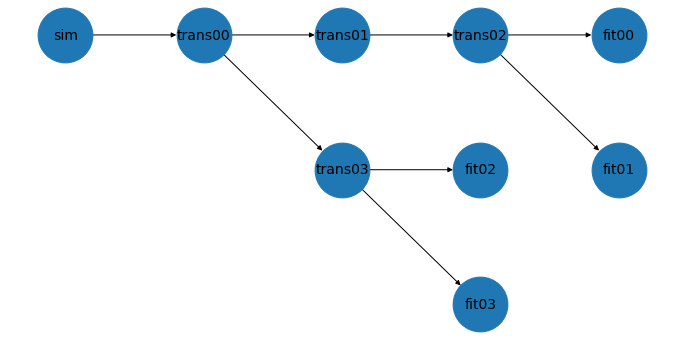

In [9]:
# Plot the workflow
wf.plot()

## Execute

Lastly, the `WorkFlow` is executed in parallel using the `run` method. The the `return_attrs` arguments is used to transfer any attribute in the model class (here a `FOOOF` object), including the model itself, to the `results` attribute of the `WorkFlow` class. Below we return both the model and attributes of the model.

In [10]:
# Execute workflow
wf.run(n_jobs=-1)

# Access results
wf.results

[[<fooof.objs.fit.FOOOF at 0x7fb7e5f58040>,